In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationInference] Initialized
  Device: cuda
  Model loaded from: SavedModels/demo_model_sota.pth
  Target size: (1024, 1024)
  Global contrast normalization: True


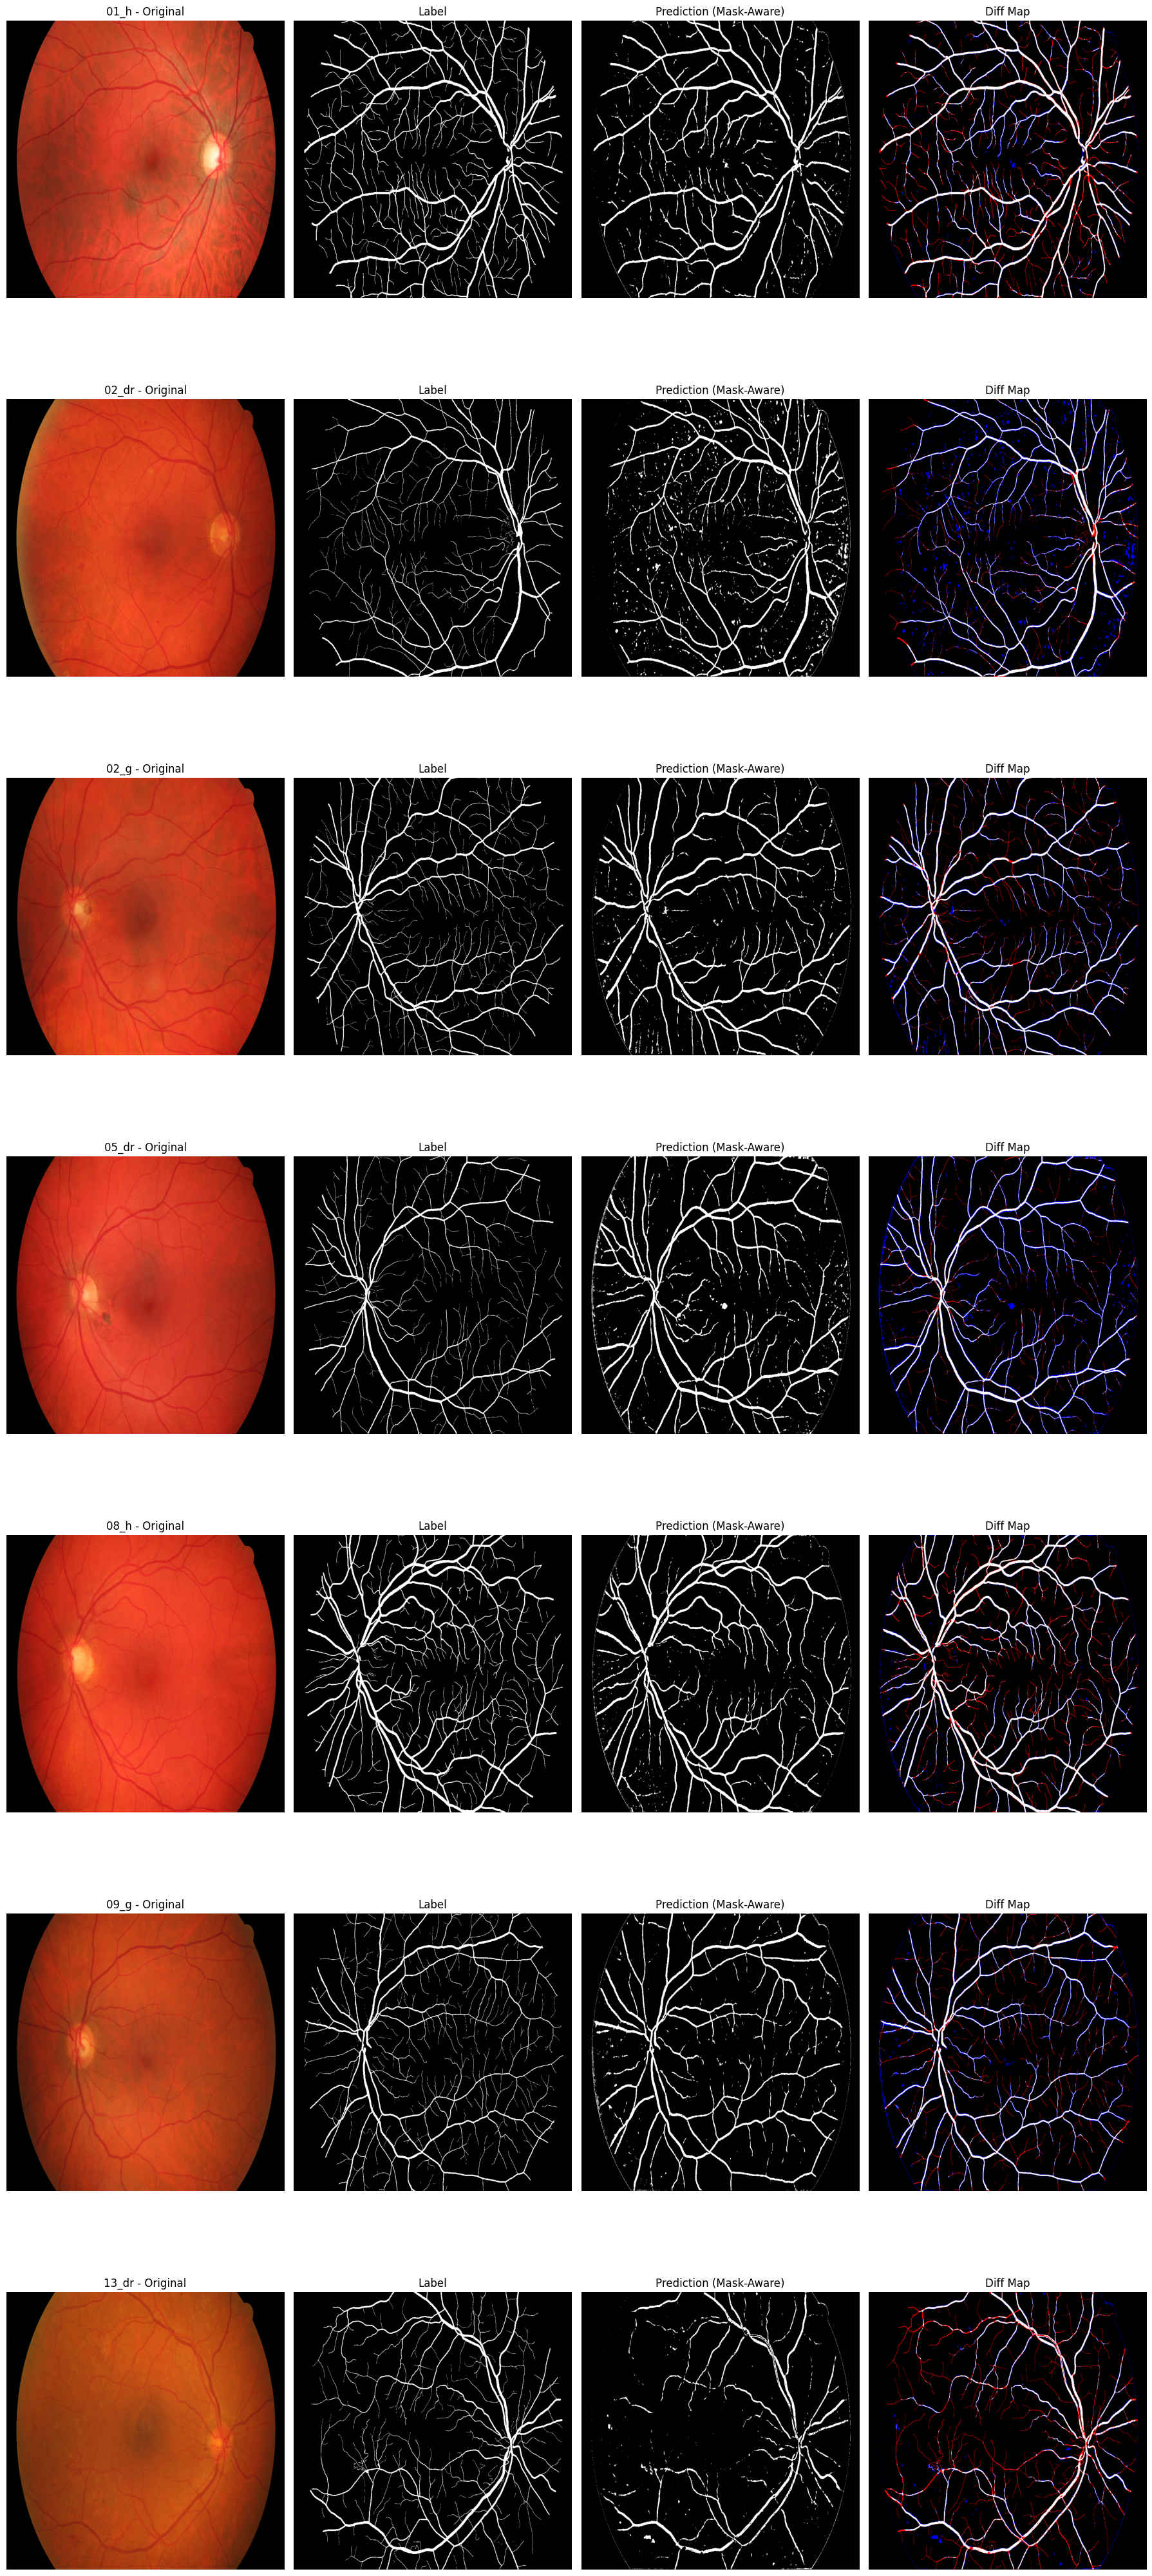

In [4]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), '..'))
from Data.DatasetSupplier import DatasetSupplier
from Util.Visualisation import Visualisation
import cv2
import numpy as np
import torch
import yaml
import matplotlib.pyplot as plt

from Core.inference import VesselSegmentationInference
from Core.dataset import VesselSegmentationDataset
from torch.utils.data import DataLoader
from Util.config import Config

config = Config.load('config_unet.yaml')

dataset = DatasetSupplier.get_dataset('config_unet.yaml')

test_basenames = ['02_g', '09_g', '01_h', '05_dr', '13_dr', '08_h', '02_dr']

test_samples = [item for item in dataset if item[0] in test_basenames]

data_tuples = [(img_path, mask_path, label_path) for (base, img_path, label_path, mask_path) in test_samples]
test_dataset = VesselSegmentationDataset(
    data_tuples,
    image_transform=None,  # Use default transform (to tensor, normalization)
    target_size=tuple(config['resize_shape']),
    global_contrast_normalization=config.get('preprocessing', {}).get('global_contrast_normalization', False)
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inference_engine = VesselSegmentationInference(
    model_path='SavedModels/demo_model_sota.pth',
    config_path='config_unet.yaml',
    device=config.get('device', None)
)

fig, axes = plt.subplots(len(test_samples), 4, figsize=(18, 6 * len(test_samples)))
if len(test_samples) == 1:
    axes = [axes]

for i, batch in enumerate(test_loader):
    img = batch['image'][0]  # [3, H, W]
    label = batch['label'][0][0].cpu().numpy() * 255  # [H, W]
    mask = batch['mask'][0][0].cpu().numpy()
    base_name = batch['base_name'][0]

    # Run inference using Core inference (single image)
    img_np = img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    img_np_uint8 = (img_np * 255).astype(np.uint8)
    pred_bin, pred_prob = inference_engine.predict_single(
        image=img_np_uint8,
        mask=None,
        threshold=config['inference']['threshold'],
        return_probability=True
    )
    # Mask the predictions: set predictions outside mask to 0
    pred_bin_masked = np.where(mask > 0.5, pred_bin, 0).astype(np.uint8)
    pred_map = pred_bin_masked * 255
    diff_map = np.abs(label.astype(np.float32) - pred_map.astype(np.float32))

    Visualisation.plot_comparison_row(
        img_np, label, pred_map, axes_row=axes[i],
        original_title=f"{base_name} - Original",
        label_title="Label",
        prediction_title="Prediction (Mask-Aware)",
        diff_map_title="Diff Map"
    )

plt.tight_layout()
plt.show()

In [ ]:
from Core.inference import VesselSegmentationInference
from Core.dataset import VesselSegmentationDataset
from torch.utils.data import DataLoader
from Data.DatasetSupplier import DatasetSupplier
import maplotlib.pyplot as plt

dataset = DatasetSupplier.get_dataset('config_unet.yaml')

test_basenames = ['02_g', '09_g', '01_h', '05_dr', '13_dr', '08_h', '02_dr']

test_samples = [item for item in dataset if item[0] in test_basenames]

data_tuples = [(img_path, mask_path, label_path) for (base, img_path, label_path, mask_path) in test_samples]

# Prepare test dataset and dataloader using Core methods
test_dataset_core = VesselSegmentationDataset(
    data_tuples,
    image_transform=None,
    target_size=tuple(config['resize_shape']),
    global_contrast_normalization=config.get('preprocessing', {}).get('global_contrast_normalization', False)
)
test_loader_core = DataLoader(test_dataset_core, batch_size=1, shuffle=False)

inference_core = VesselSegmentationInference(
    model_path='SavedModels/unet_best.pth',
    config_path='config_unet.yaml',
    device=config.get('device', None)
)

# Run inference and visualize results using Core pipeline
fig_core, axes_core = plt.subplots(len(test_samples), 4, figsize=(18, 6 * len(test_samples)))
if len(test_samples) == 1:
    axes_core = [axes_core]

for idx, batch in enumerate(test_loader_core):
    img = batch['image'][0]
    label = batch['label'][0][0].cpu().numpy() * 255
    mask = batch['mask'][0][0].cpu().numpy()
    base_name = batch['base_name'][0]

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np_uint8 = (img_np * 255).astype(np.uint8)
    pred_bin, pred_prob = inference_core.predict_single(
        image=img_np_uint8,
        mask=None,
        threshold=config['inference']['threshold'],
        return_probability=True
    )
    pred_bin_masked = np.where(mask > 0.5, pred_bin, 0).astype(np.uint8)
    pred_map = pred_bin_masked * 255
    diff_map = np.abs(label.astype(np.float32) - pred_map.astype(np.float32))

    Visualisation.plot_comparison_row(
        img_np, label, pred_map, axes_row=axes_core[idx],
        original_title=f"{base_name} - Original",
        label_title="Label",
        prediction_title="Prediction (Mask-Aware)",
        diff_map_title="Diff Map"
    )

plt.tight_layout()
plt.show()

[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationInference] Initialized
  Device: cuda
  Model loaded from: SavedModels/unet_best.pth
  Target size: (1024, 1024)
  Global contrast normalization: True


NameError: name 'plt' is not defined

[VesselSegmentationTrainer] Initialized with device: cuda
[VesselSegmentationTrainer] Config loaded from: config_unet.yaml
[VesselSegmentationTrainer] Preparing data...
Found 42 complete data samples
Dataset split: Train=29, Val=6, Test=7
[VesselSegmentationDataset] Initialized with 29 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationDataset] Initialized with 6 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationDataset] Initialized with 7 samples
[VesselSegmentationDataset] Target size: (1024, 1024)
[VesselSegmentationDataset] GCN enabled: True
[VesselSegmentationTrainer] Data preparation complete
  Train batches: 8
  Val batches: 2
  Test batches: 2
[VesselSegmentationTrainer] Initializing model...
[VesselSegmentationTrainer] Model initialized
  Total parameters: 7,763,074
  Trainable parameters: 7,763,074
  Learning rate: 0.0001
  L

f:\source\repos\wykrywanie-naczyn-dna-siatkowki-oka\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/30] (139.2s)
  Train Loss: 1.1974
  Val Loss: 1.7801
  Val IoU: 0.0000
  Val F1: 0.0000
  New best model saved! IoU: 0.0002
Epoch [2/30] (139.5s)
  Train Loss: 0.7037
  Val Loss: 1.7928
  Val IoU: 0.0002
  Val F1: 0.0005
  New best model saved! IoU: 0.0159
Epoch [3/30] (150.5s)
  Train Loss: 0.4342
  Val Loss: 1.8247
  Val IoU: 0.0159
  Val F1: 0.0313
  New best model saved! IoU: 0.4651
Epoch [4/30] (141.7s)
  Train Loss: 0.2900
  Val Loss: 1.4500
  Val IoU: 0.4651
  Val F1: 0.6349
  New best model saved! IoU: 0.8473
Epoch [5/30] (139.1s)
  Train Loss: 0.2086
  Val Loss: 0.5924
  Val IoU: 0.8473
  Val F1: 0.9173
  New best model saved! IoU: 0.9241
Epoch [6/30] (140.3s)
  Train Loss: 0.1617
  Val Loss: 0.3027
  Val IoU: 0.9241
  Val F1: 0.9605
  New best model saved! IoU: 0.9581
Epoch [7/30] (158.1s)
  Train Loss: 0.1203
  Val Loss: 0.1901
  Val IoU: 0.9581
  Val F1: 0.9786
  New best model saved! IoU: 0.9763
Epoch [8/30] (160.7s)
  Train Loss: 0.0933
  Val Loss: 0.1138
  Val I

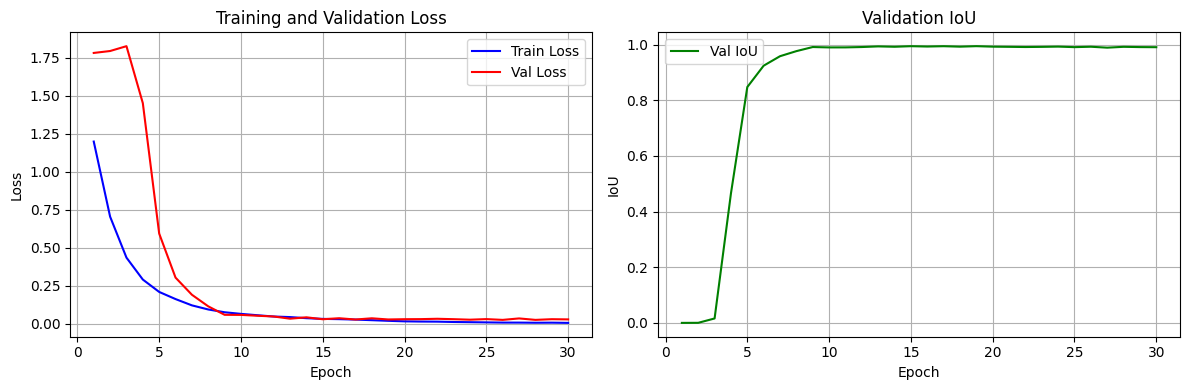

In [2]:
from Core.trainer_clean import VesselSegmentationTrainer
from Util.config import Config

config = Config.load('config_unet.yaml')

# Initialize the trainer with the config file
trainer = VesselSegmentationTrainer(config_path='config_unet.yaml')

# Prepare data splits and loaders
trainer.prepare_data(
    train_split=config['data_split']['train'],
    val_split=config['data_split']['validation'],
    test_split=config['data_split']['test'],
    target_size=tuple(config['resize_shape'])
)

# Initialize the model (parameters are taken from config by default)
trainer.initialize_model(
    in_channels=config['model']['in_channels'],
    num_classes=config['model']['num_classes'],
    base_features=config['model']['base_features']
)

# Train the model
trainer.train(
    num_epochs=config['training']['num_epochs'],
    save_path=config['model_save_path']
)

# Optionally, plot training history
trainer.plot_training_history()